# Imports and Global Variables

In [ ]:
!pip install emoji contractions tiktoken wandb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from google.colab import userdata
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import pandas as pd
import numpy
import os

from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import contractions
import string
import emoji
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.feature_extraction.text import TfidfVectorizer
from model import GPT, GPTConfig, Block, LayerNorm # Don't forget to upload model.py to /content | https://github.com/karpathy/nanoGPT/blob/master/model.py
from transformers import BertTokenizer
import torch.nn.functional as F
import torch.nn as nn
import scipy.sparse
import pandas as pd
import numpy as np
import datetime
import tiktoken
import torch
import wandb
import math
import os


### Global Variables ###
DATA_DIR = r'/content/'
SEED = "12345"
torch.manual_seed(SEED)
numpy.random.seed(SEED)
project_name = 'sentiment_classification'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Data Loading

In [ ]:
train_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
test_df = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=SEED)
train_df['data_split_type'] = "train"
val_df['data_split_type'] = "val"
test_df['data_split_type'] = "test"
df = pd.concat([train_df,val_df, test_df])
df.reset_index(drop=True, inplace=True)
df['sentiment'] = df['customer_sentiment'].map({'positive': 0, 'neutral': 1, 'negative': 2})
df['text_cleaned'] = df.conversation

# EDA

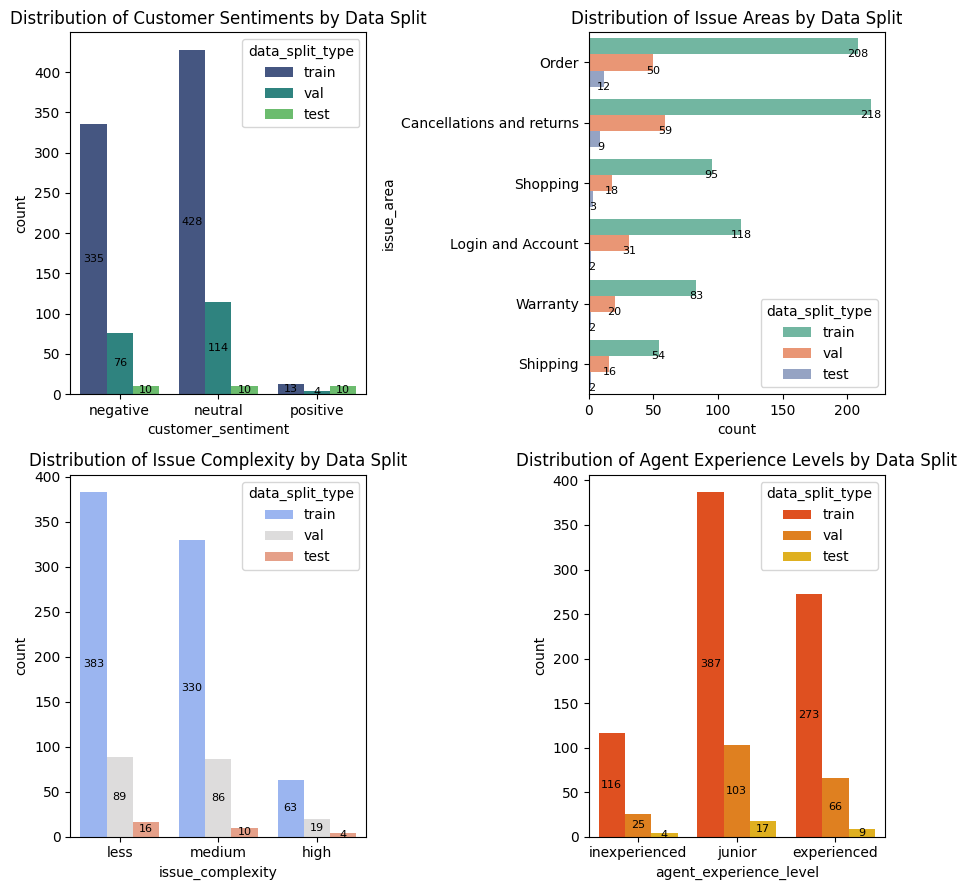

In [ ]:
plt.figure(figsize=(9, 9))

def annotate_bars_correctly(ax, horizontal=False):
    for p in ax.patches:
        _x = p.get_x() + p.get_width() / 2 if not horizontal else p.get_x() + p.get_width()
        _y = p.get_y() + p.get_height() if horizontal else p.get_y() + p.get_height() / 2
        value = int(p.get_width()) if horizontal else int(p.get_height())
        if value > 0:
            ax.text(_x, _y, value, horizontalalignment="center", verticalalignment="center", color='black', fontsize=8)

plt.subplot(2, 2, 1)
ax1 = sns.countplot(x='customer_sentiment', hue='data_split_type', data=df, palette='viridis')
plt.title('Distribution of Customer Sentiments by Data Split')
annotate_bars_correctly(ax1)

plt.subplot(2, 2, 2)
ax2 = sns.countplot(y='issue_area', hue='data_split_type', data=df, palette='Set2', dodge=True)
plt.title('Distribution of Issue Areas by Data Split')
annotate_bars_correctly(ax2, horizontal=True)

plt.subplot(2, 2, 3)
ax3 = sns.countplot(x='issue_complexity', hue='data_split_type', data=df, palette='coolwarm')
plt.title('Distribution of Issue Complexity by Data Split')
annotate_bars_correctly(ax3)

plt.subplot(2, 2, 4)
ax4 = sns.countplot(x='agent_experience_level', hue='data_split_type', data=df, order=['inexperienced', 'junior', 'experienced'], palette='autumn')
plt.title('Distribution of Agent Experience Levels by Data Split')
annotate_bars_correctly(ax4)

plt.tight_layout()
plt.show()


# PreProcess

In [ ]:
# # Only Customer Conversations | I will rerun this process with uncommenting this section when I am doing hyperparameter tunning
# df['text_cleaned'] = df['text_cleaned'].apply(
#     lambda x: "\n".join([line.split(":", 1)[1].strip() for line in x.split('\n') if line.startswith("Customer:")]))

# Lowering Case:
df['text_cleaned'] = df['text_cleaned'].str.lower()

# Update the function to remove the entire specified pattern including variations in the agent's name
def remove_full_pattern(text):
    # Extended pattern to remove, including variations in agent names
    full_pattern = r"Thank you for calling BrownBox Customer Support\. My name is \w+\. How may I assist you today\?"
    # Remove the extended pattern
    text = re.sub(full_pattern, "", text, flags=re.IGNORECASE)
    return text.strip()

# Apply the updated function to the 'conversation' column
df['text_cleaned'] = df['text_cleaned'].apply(remove_full_pattern)

# Cleaning the "Agent:" and "Customer:"
df['text_cleaned'] = df['text_cleaned'].str.replace(r"\b(Agent:|Customer:)\s*", "", regex=True)

# Remove email addresses and websites from the 'text_cleaned' column in one line
df['text_cleaned'] = df['text_cleaned'].apply(lambda text: re.sub(r"\S+@\S+|www\.\S+\.com", "", text))

# Removing punctuation, numbers, extra spaces and replacing repetitions of punctuation
df['text_cleaned'] = df['text_cleaned'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
df['text_cleaned'] = df['text_cleaned'].apply(lambda x: re.sub(r'\d+', '', x))
df['text_cleaned'] = df['text_cleaned'].apply(lambda x: ' '.join(x.split()))
df['text_cleaned'] = df['text_cleaned'].apply(lambda x: re.sub(r'(\W)\1+', r'\1', x))

# Convert Emojis to Words
def convert_emojis_to_words(text):
    converted_text = emoji.demojize(text)
    return converted_text
df['text_cleaned'] = df['text_cleaned'].apply(convert_emojis_to_words)

# Removing special characters
df['text_cleaned'] = df['text_cleaned'].apply(lambda x: re.sub(r"[^\w\s]", '', x))

# Removing contractions
df['text_cleaned'] = df['text_cleaned'].apply(lambda x: contractions.fix(x))

# Removing stop words:
stop_words_set = set(stopwords.words('english'))
no_stopwords = []
for sentence in df["text_cleaned"]:
    # Use the new variable name here
    no_stopwords.append(' '.join(word for word in sentence.split() if word not in stop_words_set))
df["text_cleaned"]=no_stopwords

# Lemmitization
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

df["text_cleaned"] = df["text_cleaned"].apply(lambda text: lemmatize_words(text))

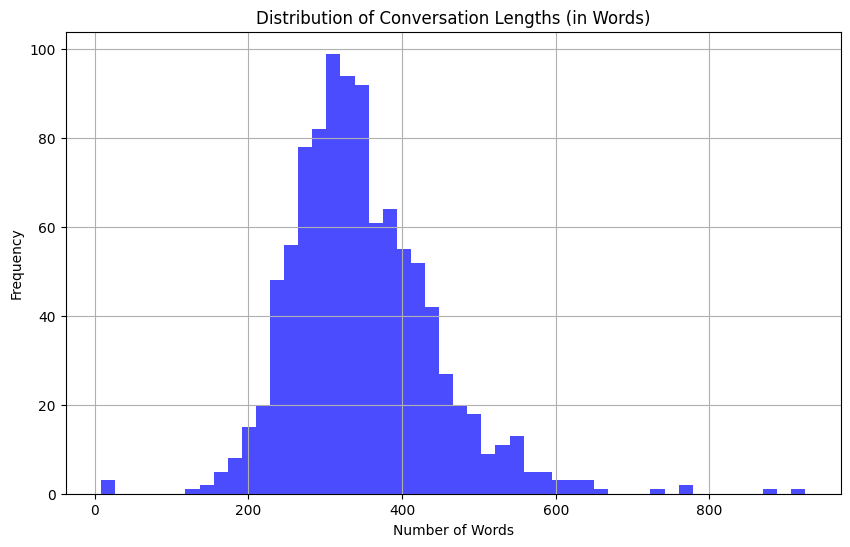

In [ ]:
# Calculate the number of words in each conversation |  Before changing the preprocess part for hyperparmater tunning
df['word_count'] = df['text_cleaned'].str.split().str.len()
df = df[~((df['word_count'] < 8) & (df['data_split_type'] == 'train'))] #Removing no conversation in train dataset
# Plotting the histogram of conversation lengths
plt.figure(figsize=(10, 6))
plt.hist(df['word_count'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Conversation Lengths (in Words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

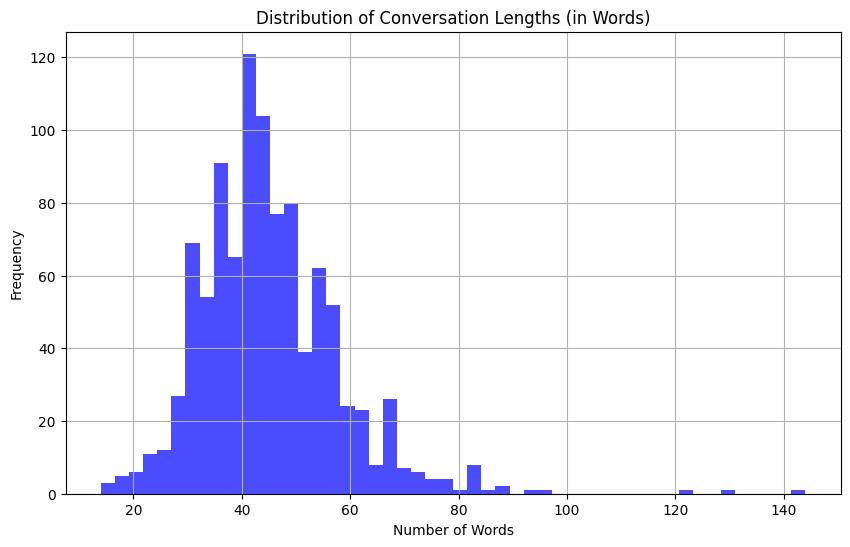

In [ ]:
# Calculate the number of words in each conversation |  After changing the preprocess part for hyperparmater tunning
df['word_count'] = df['text_cleaned'].str.split().str.len()
df = df[~((df['word_count'] < 8) & (df['data_split_type'] == 'train'))] #Removing no conversation in train dataset
# Plotting the histogram of conversation lengths
plt.figure(figsize=(10, 6))
plt.hist(df['word_count'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Conversation Lengths (in Words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Model Design

In [ ]:
class FullSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout
        # flash attention make GPU go brrrrr but support is only in PyTorch >= 2.0
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        if self.flash:
            # efficient attention using Flash Attention CUDA kernels
            y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=False)
        else:
            # manual implementation of attention
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y

class BumbleBeeBlock(Block):
    def __init__(self, config):
        super().__init__(config)
        self.attn = FullSelfAttention(config)

class BumbleBee(GPT):
    def __init__(self, config, num_classes=3): # The output of the sentimenet analysis will be 0, 1, 2.
        super().__init__(config)

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([BumbleBeeBlock(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        # Override the lm_head with a new linear layer for sentiment classification
        self.lm_head = torch.nn.Linear(config.n_embd, num_classes, bias=False)

    def forward(self, idx):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device)  # shape (t)

        # Forward the GPT model
        tok_emb = self.transformer.wte(idx)  # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos)  # position embeddings of shape (t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        # Aggregate sequence representations (average over the sequence)
        x = torch.mean(x, dim=1)

        # Pass through the modified linear layer to get class logits
        logits = self.lm_head(x)

        return logits

    @classmethod
    def from_pretrained(cls, model_type, override_args=None):
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        override_args = override_args or {} # default to empty dict
        # only dropout can be overridden see more notes below
        assert all(k == 'dropout' for k in override_args)
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        print("forcing vocab_size=50257, block_size=1024, bias=True")
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        config_args['bias'] = True # always True for GPT model checkpoints
        # we can override the dropout rate, if desired
        if 'dropout' in override_args:
            print(f"overriding dropout rate to {override_args['dropout']}")
            config_args['dropout'] = override_args['dropout']
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = BumbleBee(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                if k != 'lm_head.weight': # Except Last layer
                    assert sd_hf[k].shape == sd[k].shape
                    with torch.no_grad():
                        sd[k].copy_(sd_hf[k])

        return model

class CustomerSentimentDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=256, text_column='text_cleaned', sentiment_column='sentiment',):
        self.data = df
        self.texts = self.data[text_column].values
        self.labels = self.data[sentiment_column].values
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Use the tokenizer's method to encode the text
        input_ids = self.tokenizer.encode(text)

        # Ensure the sequence is at most max_length
        input_ids = input_ids[:self.max_length]

        # Padding if necessary to ensure all sequences are of the same length
        padding_length = self.max_length - len(input_ids)
        if padding_length > 0:
            # Append zeros at the end for padding
            input_ids = input_ids + [0] * padding_length

        # Ensure it returns a torch tensor
        input_ids = torch.tensor(input_ids, dtype=torch.long)

        return input_ids, torch.tensor(label, dtype=torch.long)

# Training & Evaluation Metric Definations

In [ ]:
def train_and_evaluate():
    current_time = datetime.datetime.now().strftime("%d-%m-%Y_%H-%M-%S")
    wandb.init(project="customser_service_sentiment_analysis", name=f"run_{current_time}")
    config = wandb.config

    if config.init_from == 'scratch':
        model_config = GPTConfig(vocab_size=config.vocab_size, block_size=config.block_size,
                             n_layer=config.n_layer, n_head=config.n_head,
                             n_embd=config.n_embd, dropout=config.dropout)
        model = BumbleBee(model_config).to(device)
    elif str(config.init_from).startswith('gpt'):
        model_config = dict(dropout=config.dropout)
        model = BumbleBee.from_pretrained(model_type=config.init_from, override_args=model_config).to(device)
    else:
        print('please select correct model!')

    optimizer = model.configure_optimizers(weight_decay=config.weight_decay,
                                           learning_rate=config.learning_rate,
                                           betas=(config.beta1, config.beta2),
                                           device_type=device)

    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

    best_f1_macro = 0
    best_val_loss = float('inf')
    best_model_path = ""

    for epoch in range(config.epochs):
        model.train()
        # Initialize lists to store batch metrics
        train_losses, train_f1s, train_precs, train_recs, train_accs = [], [], [], [], []
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            logits = model(inputs)
            loss = F.cross_entropy(logits, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)
            optimizer.step()

            # Calculate and store batch metrics
            train_losses.append(loss.item())
            predictions = logits.argmax(dim=1).cpu().numpy()
            labels_np = labels.cpu().numpy()
            train_f1s.append(f1_score(labels_np, predictions, average='macro'))
            train_precs.append(precision_score(labels_np, predictions, average='macro', zero_division=0))
            train_recs.append(recall_score(labels_np, predictions, average='macro', zero_division=0))
            train_accs.append(accuracy_score(labels_np, predictions))

        # Calculate average metrics over all batches
        avg_train_loss = np.mean(train_losses)
        avg_train_f1 = np.mean(train_f1s)
        avg_train_prec = np.mean(train_precs)
        avg_train_rec = np.mean(train_recs)
        avg_train_acc = np.mean(train_accs)

        model.eval()
        val_loss, val_f1, val_prec, val_rec, val_acc, val_conf_matrix = evaluate(model, val_loader)
        print(f"\nEpoch {epoch+1}, Train Loss: {avg_train_loss:.2f}, Train F1 Macro: {avg_train_f1:.2f}, Train Precision Macro: {avg_train_prec:.2f}, Train Recall Macro: {avg_train_rec:.2f}, Train Accuracy: {avg_train_acc:.2f}")
        print(f"Epoch {epoch+1}, Val Loss: {val_loss:.2f}, Val F1 Macro: {val_f1:.2f}, Val Precision Macro: {val_prec:.2f}, Val Recall Macro: {val_rec:.2f}, Val Accuracy: {val_acc:.2f}")

        # Saving the best F1 macro result model
        if val_f1 > best_f1_macro:
            best_f1_macro = val_f1
            best_model_path = f"{DATA_DIR}/best_model_{current_time}.pt"
            checkpoint = {
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'model_args': model_config,
                'epoch_num': epoch+1,
                'best_val_loss': best_val_loss,
                'config': {k: v for k, v in dict(wandb.config).items()},
            }
            torch.save(checkpoint, best_model_path)

        # Log both training and validation metrics to W&B
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": avg_train_loss, "train_f1_macro": avg_train_f1, "train_precision_macro": avg_train_prec, "train_recall_macro": avg_train_rec, "train_accuracy": avg_train_acc,
            "val_loss": val_loss, "val_f1_macro": val_f1, "val_precision_macro": val_prec, "val_recall_macro": val_rec, "val_accuracy": val_acc
        })

    # Load the best model and evaluate on test data
    model.load_state_dict(torch.load(best_model_path)['model'])
    test_loss, test_f1, test_prec, test_rec, test_acc, test_conf_matrix = evaluate(model, test_loader)
    print(f"\nBest model epoch {checkpoint['epoch_num']} and test results, Test Loss: {test_loss:.2f}, Test F1 Macro: {test_f1:.2f}, Test Precision Macro: {test_prec:.2f}, Test Recall Macro: {test_rec:.2f}, Test Accuracy: {test_acc:.2f}")


    fig = plot_confusion_matrix(test_conf_matrix, class_names=['Positive', 'Neutral', 'Negative'])
    wandb.log({"test_confusion_matrix": wandb.Image(fig)})

    # Log test results to W&B
    wandb.log(
              {"test_loss": test_loss,
               "test_f1_macro": test_f1,
               "test_precision_macro": test_prec,
               "test_recall_macro": test_rec}
              )
    wandb.finish()


def evaluate(model, loader):
    total_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            logits = model(inputs)
            loss = F.cross_entropy(logits, labels)
            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    precision_macro = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall_macro = recall_score(all_labels, all_preds, average='macro')
    conf_matrix = confusion_matrix(all_labels, all_preds)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, f1_macro, precision_macro, recall_macro, accuracy, conf_matrix

def plot_confusion_matrix(cm, class_names):
    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues, cbar=False, xticklabels=class_names, yticklabels=class_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.close()
    return figure


# From Scratch

In [ ]:
# Assigning tokinezer
tokenizer = tiktoken.get_encoding("gpt2")

# Load the dataset
train_dataset = CustomerSentimentDataset(df[df.data_split_type == 'train'], max_length=1024, tokenizer=tokenizer)
test_dataset = CustomerSentimentDataset(df[df.data_split_type == 'test'], max_length=1024, tokenizer=tokenizer)
val_dataset = CustomerSentimentDataset(df[df.data_split_type == 'val'], max_length=1024, tokenizer=tokenizer)

In [ ]:
sweep_config = {
    'method': 'grid',
    'parameters': {
        'epochs': {
            'value': 30
        },
        'batch_size': {
            'values': [32]
        },
        'vocab_size': {
            'values': [50304]
        },
        'block_size': {
            'values': [1024]
        },
        'n_layer': {
            'values': [6]
        },
        'n_head': {
            'values': [6]
        },
        'n_embd': {
            'values': [384]
        },
        'dropout': {
           'values': [0.3]
        },
        'learning_rate': {
            'values': [0.0001]
        },
        'weight_decay': {
            'values': [0.01]
        },
        'max_grad_norm': {
            'values': [1.0]
        },
        'beta1': {
            'values': [0.9]
        },
        'beta2': {
            'values': [0.999]
        },
        'init_from': {
            'value': 'scratch'
        },
    }
}

sweep_id = wandb.sweep(sweep_config, project=project_name)

wandb.agent(sweep_id=sweep_id, function=train_and_evaluate)

Create sweep with ID: fy5ekp7q
Sweep URL: https://wandb.ai/halildonmezbilek/di725-assignment1/sweeps/fy5ekp7q


wandb: Agent Starting Run: qfesymub with config:
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	block_size: 1024
wandb: 	dropout: 0.3
wandb: 	epochs: 30
wandb: 	init_from: scratch
wandb: 	learning_rate: 0.0001
wandb: 	max_grad_norm: 1
wandb: 	n_embd: 384
wandb: 	n_head: 6
wandb: 	n_layer: 6
wandb: 	vocab_size: 50304
wandb: 	weight_decay: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


number of parameters: 29.96M
num decayed parameter tensors: 27, with 30,327,936 parameters
num non-decayed parameter tensors: 50, with 30,720 parameters
using fused AdamW: True

Epoch 1, Train Loss: 0.81, Train F1 Macro: 0.36, Train Precision Macro: 0.36, Train Recall Macro: 0.47, Train Accuracy: 0.50
Epoch 1, Val Loss: 0.71, Val F1 Macro: 0.28, Val Precision Macro: 0.47, Val Recall Macro: 0.35, Val Accuracy: 0.60

Epoch 2, Train Loss: 0.71, Train F1 Macro: 0.53, Train Precision Macro: 0.58, Train Recall Macro: 0.55, Train Accuracy: 0.64
Epoch 2, Val Loss: 0.62, Val F1 Macro: 0.42, Val Precision Macro: 0.51, Val Recall Macro: 0.43, Val Accuracy: 0.69

Epoch 3, Train Loss: 0.69, Train F1 Macro: 0.57, Train Precision Macro: 0.59, Train Recall Macro: 0.58, Train Accuracy: 0.67
Epoch 3, Val Loss: 0.62, Val F1 Macro: 0.38, Val Precision Macro: 0.50, Val Recall Macro: 0.40, Val Accuracy: 0.66

Epoch 4, Train Loss: 0.66, Train F1 Macro: 0.58, Train Precision Macro: 0.61, Train Recall Macro: 0

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
test_f1_macro,▁
test_loss,▁
test_precision_macro,▁
test_recall_macro,▁
train_accuracy,▁▃▄▄▅▆▆▆▇▇▇▇▆▇▇███▇▇▇▇▇███████
train_f1_macro,▁▃▄▄▅▅▆▆▇▇▆▆▆▆▇▇▇█▇▇▇▇▇█▇▇███▇
train_loss,█▇▇▇▆▅▅▄▃▃▃▄▄▃▃▂▂▂▃▂▂▂▂▁▁▁▁▂▁▁
train_precision_macro,▁▄▄▄▅▅▆▆▇▇▆▇▆▇▇▇▇█▇▇▇▇▇█▇▇███▇
train_recall_macro,▁▂▃▃▄▅▅▅▆▇▆▆▆▆▇▇▇█▇▇▇▇▇█▇▇▇▇█▇
val_accuracy,▂▄▃▆▆████▄▇▁▇████▇█▂█▇▆▇▆▇▆▇▇▇


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


# Fine Tunning

In [ ]:
# Assigning tokinezer
tokenizer = tiktoken.get_encoding("gpt2")

# Load the dataset
train_dataset = CustomerSentimentDataset(df[df.data_split_type == 'train'], max_length=1024, tokenizer=tokenizer)
test_dataset = CustomerSentimentDataset(df[df.data_split_type == 'test'], max_length=1024, tokenizer=tokenizer)
val_dataset = CustomerSentimentDataset(df[df.data_split_type == 'val'], max_length=1024, tokenizer=tokenizer)

In [ ]:
sweep_config = {
    'method': 'grid',
    'parameters': {
        'epochs': {
            'value': 30
        },
        'batch_size': {
            'values': [32]
        },
        'dropout': {
           'values': [0.3]
        },
        'learning_rate': {
            'values': [0.001]
        },
        'weight_decay': {
            'values': [0.1]
        },
        'max_grad_norm': {
            'values': [1.0]
        },
        'beta1': {
            'values': [0.9]
        },
        'beta2': {
            'values': [0.999]
        },
        'init_from': {
            'value': 'gpt2'
        },
    }
}


sweep_id = wandb.sweep(sweep_config, project=project_name)

wandb.agent(sweep_id=sweep_id, function=train_and_evaluate)

Create sweep with ID: l03vzyc1
Sweep URL: https://wandb.ai/halildonmezbilek/di725-assignment1/sweeps/l03vzyc1


wandb: Agent Starting Run: o7n193ow with config:
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dropout: 0.3
wandb: 	epochs: 30
wandb: 	init_from: gpt2
wandb: 	learning_rate: 0.001
wandb: 	max_grad_norm: 1
wandb: 	weight_decay: 0.1
wandb: Currently logged in as: halil-donmezbilek (halildonmezbilek). Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


loading weights from pretrained gpt: gpt2
forcing vocab_size=50257, block_size=1024, bias=True
overriding dropout rate to 0.3
number of parameters: 123.65M
num decayed parameter tensors: 51, with 124,320,768 parameters
num non-decayed parameter tensors: 98, with 121,344 parameters
using fused AdamW: True

Epoch 1, Train Loss: 0.97, Train F1 Macro: 0.29, Train Precision Macro: 0.23, Train Recall Macro: 0.43, Train Accuracy: 0.49
Epoch 1, Val Loss: 0.85, Val F1 Macro: 0.19, Val Precision Macro: 0.13, Val Recall Macro: 0.33, Val Accuracy: 0.39

Epoch 2, Train Loss: 0.81, Train F1 Macro: 0.31, Train Precision Macro: 0.24, Train Recall Macro: 0.45, Train Accuracy: 0.54
Epoch 2, Val Loss: 0.77, Val F1 Macro: 0.26, Val Precision Macro: 0.42, Val Recall Macro: 0.34, Val Accuracy: 0.59

Epoch 3, Train Loss: 0.77, Train F1 Macro: 0.39, Train Precision Macro: 0.41, Train Recall Macro: 0.50, Train Accuracy: 0.56
Epoch 3, Val Loss: 0.65, Val F1 Macro: 0.45, Val Precision Macro: 0.47, Val Recall Mac

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
test_f1_macro,▁
test_loss,▁
test_precision_macro,▁
test_recall_macro,▁
train_accuracy,▁▂▂▄▅▆▆▆▆▇▆▇▇▇▇█▇▇▇███████████
train_f1_macro,▁▁▂▄▅▅▅▆▆▆▆▆▆▇▆▇▆▆▆▆▇▇▇▇▇████▇
train_loss,█▇▆▆▅▄▄▄▄▃▃▃▃▃▂▂▃▃▂▂▂▂▁▂▁▁▁▁▁▁
train_precision_macro,▁▁▃▅▅▆▆▆▆▆▆▇▆▇▆▇▇▆▆▇▇▇▇▇█████▇
train_recall_macro,▁▁▂▃▄▄▅▅▆▆▅▆▆▆▆▇▆▆▆▆▆▇▇▇▇███▇▇
val_accuracy,▁▄▅▇▇██▇▇▇█▇▇██▇▇██████▇███▇▇▇


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


# Hyperparameter Tuning

In [ ]:

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
max_length = 128

# Tokenize the data
X_train_encoded = tokenizer.batch_encode_plus(df['text_cleaned'][df['data_split_type'] == 'train'].tolist(),
                                              padding=True,
                                              truncation=True,
                                              max_length = max_length,
                                              return_tensors='pt')['input_ids']

X_val_encoded = tokenizer.batch_encode_plus(df['text_cleaned'][df['data_split_type'] == 'val'].tolist(),
                                              padding=True,
                                              truncation=True,
                                              max_length = max_length,
                                              return_tensors='pt')['input_ids']

X_test_encoded = tokenizer.batch_encode_plus(df['text_cleaned'][df['data_split_type'] == 'test'].tolist(),
                                              padding=True,
                                              truncation=True,
                                              max_length = max_length,
                                              return_tensors='pt')['input_ids']


class BERTDataset(Dataset):
  def __init__(self, encoded_inputs, labels):
      """
      Args:
          encoded_inputs (torch.Tensor): Pre-encoded input IDs for training/validation/testing.
          labels (list of int): Corresponding labels for the input data.
      """
      self.encoded_inputs = encoded_inputs
      self.labels = torch.tensor(labels, dtype=torch.long)

  def __len__(self):
      return len(self.labels)

  def __getitem__(self, idx):
      """
      Returns:
          input_ids: the pre-encoded tensor of input IDs (as a detached copy)
          label: the label for the input IDs at this index
      """
      input_ids = self.encoded_inputs[idx].clone().detach()
      label = self.labels[idx]
      return input_ids, label

train_labels = df[df['data_split_type'] == 'train']['sentiment'].tolist()
val_labels = df[df['data_split_type'] == 'val']['sentiment'].tolist()
test_labels = df[df['data_split_type'] == 'test']['sentiment'].tolist()

train_dataset = BERTDataset(X_train_encoded, train_labels)
val_dataset = BERTDataset(X_val_encoded, val_labels)
test_dataset = BERTDataset(X_test_encoded, test_labels)


In [ ]:
sweep_config = {
    'method': 'grid',
    'parameters': {
        'epochs': {
            'value': 30
        },
        'batch_size': {
            'values': [32]
        },
        'dropout': {
           'values': [0.3]
        },
        'learning_rate': {
            'values': [0.001, 0.0001]
        },
        'weight_decay': {
            'values': [0.1, 1.5]
        },
        'max_grad_norm': {
            'values': [0.5, 1.0]
        },
        'beta1': {
            'values': [0.9]
        },
        'beta2': {
            'values': [0.999]
        },
        'init_from': {
            'value': 'gpt2'
        },
    }
}

sweep_id = wandb.sweep(sweep_config, project=project_name)

wandb.agent(sweep_id=sweep_id, function=train_and_evaluate)

Create sweep with ID: hvg2dq18
Sweep URL: https://wandb.ai/halildonmezbilek/di725-assignment1/sweeps/hvg2dq18


wandb: Agent Starting Run: u7nfilmb with config:
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dropout: 0.3
wandb: 	epochs: 30
wandb: 	init_from: gpt2
wandb: 	learning_rate: 0.001
wandb: 	max_grad_norm: 0.5
wandb: 	weight_decay: 0.1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


loading weights from pretrained gpt: gpt2
forcing vocab_size=50257, block_size=1024, bias=True
overriding dropout rate to 0.3
number of parameters: 123.65M
num decayed parameter tensors: 51, with 124,320,768 parameters
num non-decayed parameter tensors: 98, with 121,344 parameters
using fused AdamW: True

Epoch 1, Train Loss: 1.05, Train F1 Macro: 0.30, Train Precision Macro: 0.29, Train Recall Macro: 0.42, Train Accuracy: 0.49
Epoch 1, Val Loss: 0.74, Val F1 Macro: 0.42, Val Precision Macro: 0.44, Val Recall Macro: 0.45, Val Accuracy: 0.62

Epoch 2, Train Loss: 0.66, Train F1 Macro: 0.55, Train Precision Macro: 0.63, Train Recall Macro: 0.60, Train Accuracy: 0.68
Epoch 2, Val Loss: 0.57, Val F1 Macro: 0.50, Val Precision Macro: 0.57, Val Recall Macro: 0.49, Val Accuracy: 0.77

Epoch 3, Train Loss: 0.58, Train F1 Macro: 0.66, Train Precision Macro: 0.71, Train Recall Macro: 0.67, Train Accuracy: 0.79
Epoch 3, Val Loss: 0.50, Val F1 Macro: 0.55, Val Precision Macro: 0.54, Val Recall Mac

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
test_f1_macro,▁
test_loss,▁
test_precision_macro,▁
test_recall_macro,▁
train_accuracy,▁▄▅▆▇▇████████████████████████
train_f1_macro,▁▄▅▆▆▆▇▇▇▇████████████████████
train_loss,█▅▅▃▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_precision_macro,▁▄▅▆▆▆▇▇▇▇████████████████████
train_recall_macro,▁▃▄▆▆▆▆▇▆▇▇▇▇█████████████████
val_accuracy,▁▄▅▇▇███▇██▇▇██▇▇▇▇█▇█▇▇██████


wandb: Agent Starting Run: o8oqfs0j with config:
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dropout: 0.3
wandb: 	epochs: 30
wandb: 	init_from: gpt2
wandb: 	learning_rate: 0.001
wandb: 	max_grad_norm: 0.5
wandb: 	weight_decay: 1.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


loading weights from pretrained gpt: gpt2
forcing vocab_size=50257, block_size=1024, bias=True
overriding dropout rate to 0.3
number of parameters: 123.65M
num decayed parameter tensors: 51, with 124,320,768 parameters
num non-decayed parameter tensors: 98, with 121,344 parameters
using fused AdamW: True

Epoch 1, Train Loss: 0.94, Train F1 Macro: 0.30, Train Precision Macro: 0.24, Train Recall Macro: 0.43, Train Accuracy: 0.50
Epoch 1, Val Loss: 0.88, Val F1 Macro: 0.25, Val Precision Macro: 0.20, Val Recall Macro: 0.33, Val Accuracy: 0.59

Epoch 2, Train Loss: 0.81, Train F1 Macro: 0.32, Train Precision Macro: 0.26, Train Recall Macro: 0.46, Train Accuracy: 0.54
Epoch 2, Val Loss: 0.73, Val F1 Macro: 0.27, Val Precision Macro: 0.45, Val Recall Macro: 0.34, Val Accuracy: 0.60

Epoch 3, Train Loss: 0.61, Train F1 Macro: 0.60, Train Precision Macro: 0.68, Train Recall Macro: 0.63, Train Accuracy: 0.73
Epoch 3, Val Loss: 0.66, Val F1 Macro: 0.52, Val Precision Macro: 0.51, Val Recall Mac

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
test_f1_macro,▁
test_loss,▁
test_precision_macro,▁
test_recall_macro,▁
train_accuracy,▁▂▄▆▆▇▇███████████████████████
train_f1_macro,▁▁▄▅▆▆▆▆▇▇▇███████████▇▇██▇███
train_loss,█▇▆▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▂▁▁▂▁▁▁
train_precision_macro,▁▁▅▆▆▆▇▆▇▇▇███████████▇▇██▇███
train_recall_macro,▁▁▃▅▅▆▆▆▇▇▇▇██████████▇▇██▇███
val_accuracy,▁▁▅▆▇▇█▇█▅████▆▇█▇▇█▇█▆▇▇▇█▇▆▇


wandb: Agent Starting Run: 6d96ft9d with config:
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dropout: 0.3
wandb: 	epochs: 30
wandb: 	init_from: gpt2
wandb: 	learning_rate: 0.001
wandb: 	max_grad_norm: 1
wandb: 	weight_decay: 0.1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


loading weights from pretrained gpt: gpt2
forcing vocab_size=50257, block_size=1024, bias=True
overriding dropout rate to 0.3
number of parameters: 123.65M
num decayed parameter tensors: 51, with 124,320,768 parameters
num non-decayed parameter tensors: 98, with 121,344 parameters
using fused AdamW: True

Epoch 1, Train Loss: 0.80, Train F1 Macro: 0.34, Train Precision Macro: 0.29, Train Recall Macro: 0.46, Train Accuracy: 0.56
Epoch 1, Val Loss: 0.90, Val F1 Macro: 0.26, Val Precision Macro: 0.53, Val Recall Macro: 0.34, Val Accuracy: 0.59

Epoch 2, Train Loss: 0.76, Train F1 Macro: 0.46, Train Precision Macro: 0.47, Train Recall Macro: 0.55, Train Accuracy: 0.61
Epoch 2, Val Loss: 1.54, Val F1 Macro: 0.35, Val Precision Macro: 0.43, Val Recall Macro: 0.41, Val Accuracy: 0.54

Epoch 3, Train Loss: 0.64, Train F1 Macro: 0.68, Train Precision Macro: 0.71, Train Recall Macro: 0.70, Train Accuracy: 0.79
Epoch 3, Val Loss: 0.79, Val F1 Macro: 0.51, Val Precision Macro: 0.52, Val Recall Mac

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
test_f1_macro,▁
test_loss,▁
test_precision_macro,▁
test_recall_macro,▁
train_accuracy,▁▂▅▆▇▇▇▇██████████████████████
train_f1_macro,▁▂▅▆▆▆▇▆▆▆▆▆▆▆▇▇▇▇█▇▇▇██████▇█
train_loss,██▇▄▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_precision_macro,▁▃▅▆▆▆▇▆▆▆▆▇▇▆▇▇▇██▇▇▇████████
train_recall_macro,▁▂▄▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇█▇▇▇▇█████▇█
val_accuracy,▂▁▅▆▇▇█▇▇██▇▇▇▆▇▇▇▆▆▅▆▆▇▇▇▇▆▇▇


wandb: Agent Starting Run: ki6s8azn with config:
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dropout: 0.3
wandb: 	epochs: 30
wandb: 	init_from: gpt2
wandb: 	learning_rate: 0.001
wandb: 	max_grad_norm: 1
wandb: 	weight_decay: 1.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


loading weights from pretrained gpt: gpt2
forcing vocab_size=50257, block_size=1024, bias=True
overriding dropout rate to 0.3
number of parameters: 123.65M
num decayed parameter tensors: 51, with 124,320,768 parameters
num non-decayed parameter tensors: 98, with 121,344 parameters
using fused AdamW: True

Epoch 1, Train Loss: 1.26, Train F1 Macro: 0.32, Train Precision Macro: 0.30, Train Recall Macro: 0.44, Train Accuracy: 0.53
Epoch 1, Val Loss: 0.79, Val F1 Macro: 0.25, Val Precision Macro: 0.36, Val Recall Macro: 0.33, Val Accuracy: 0.59

Epoch 2, Train Loss: 0.92, Train F1 Macro: 0.36, Train Precision Macro: 0.36, Train Recall Macro: 0.47, Train Accuracy: 0.53
Epoch 2, Val Loss: 1.12, Val F1 Macro: 0.25, Val Precision Macro: 0.20, Val Recall Macro: 0.33, Val Accuracy: 0.59

Epoch 3, Train Loss: 0.81, Train F1 Macro: 0.54, Train Precision Macro: 0.56, Train Recall Macro: 0.59, Train Accuracy: 0.68
Epoch 3, Val Loss: 0.75, Val F1 Macro: 0.26, Val Precision Macro: 0.53, Val Recall Mac

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
test_f1_macro,▁
test_loss,▁
test_precision_macro,▁
test_recall_macro,▁
train_accuracy,▁▁▃▄▆▆▇▇▇█▇██████▇████████████
train_f1_macro,▁▁▃▄▅▅▆▆▆▆▆▇▇▇▇▇▆▆▆▇▇▇████████
train_loss,█▆▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁
train_precision_macro,▁▂▄▄▆▆▆▆▆▆▆▇▇▇▇▇▆▆▆▇▇█████████
train_recall_macro,▁▁▃▄▅▅▆▆▆▆▆▆▆▇▇▇▆▆▆▇▇▇████████
val_accuracy,▁▁▁▇▆▅███▇█▇█▇▇▇█▇▇█▇█▇▇▇▇▇▇▇▇


wandb: Agent Starting Run: px8do1qd with config:
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dropout: 0.3
wandb: 	epochs: 30
wandb: 	init_from: gpt2
wandb: 	learning_rate: 0.0001
wandb: 	max_grad_norm: 0.5
wandb: 	weight_decay: 0.1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


loading weights from pretrained gpt: gpt2
forcing vocab_size=50257, block_size=1024, bias=True
overriding dropout rate to 0.3
number of parameters: 123.65M
num decayed parameter tensors: 51, with 124,320,768 parameters
num non-decayed parameter tensors: 98, with 121,344 parameters
using fused AdamW: True

Epoch 1, Train Loss: 0.88, Train F1 Macro: 0.41, Train Precision Macro: 0.45, Train Recall Macro: 0.47, Train Accuracy: 0.57
Epoch 1, Val Loss: 0.69, Val F1 Macro: 0.42, Val Precision Macro: 0.42, Val Recall Macro: 0.42, Val Accuracy: 0.64

Epoch 2, Train Loss: 0.70, Train F1 Macro: 0.53, Train Precision Macro: 0.56, Train Recall Macro: 0.55, Train Accuracy: 0.65
Epoch 2, Val Loss: 0.69, Val F1 Macro: 0.30, Val Precision Macro: 0.49, Val Recall Macro: 0.36, Val Accuracy: 0.61

Epoch 3, Train Loss: 0.68, Train F1 Macro: 0.53, Train Precision Macro: 0.57, Train Recall Macro: 0.56, Train Accuracy: 0.64
Epoch 3, Val Loss: 0.61, Val F1 Macro: 0.41, Val Precision Macro: 0.50, Val Recall Mac

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
test_f1_macro,▁
test_loss,▁
test_precision_macro,▁
test_recall_macro,▁
train_accuracy,▁▂▂▃▄▅▅▄▆▆▇▇▇▇▇▇▇▇▇▇███▇██████
train_f1_macro,▁▂▂▂▄▄▄▃▅▆▆▆▆▆▆▆▆▆▇▇█▇▇▇██████
train_loss,█▇▆▆▅▅▅▆▄▄▃▃▃▃▂▃▂▃▂▂▁▁▁▂▁▁▁▁▁▁
train_precision_macro,▁▂▃▃▄▄▄▄▅▆▆▆▆▆▆▆▆▆▇▇█▇▇▇▇█████
train_recall_macro,▁▂▂▂▃▄▄▃▅▆▆▆▅▆▆▆▆▆▇▇█▇▇▇██████
val_accuracy,▂▁▃▄▆▆▄▇▇▇▇▇▇█▇▇█▇▇█▇▇███▇▇███


wandb: Agent Starting Run: h50y9pv1 with config:
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dropout: 0.3
wandb: 	epochs: 30
wandb: 	init_from: gpt2
wandb: 	learning_rate: 0.0001
wandb: 	max_grad_norm: 0.5
wandb: 	weight_decay: 1.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


loading weights from pretrained gpt: gpt2
forcing vocab_size=50257, block_size=1024, bias=True
overriding dropout rate to 0.3
number of parameters: 123.65M
num decayed parameter tensors: 51, with 124,320,768 parameters
num non-decayed parameter tensors: 98, with 121,344 parameters
using fused AdamW: True

Epoch 1, Train Loss: 0.81, Train F1 Macro: 0.39, Train Precision Macro: 0.45, Train Recall Macro: 0.47, Train Accuracy: 0.53
Epoch 1, Val Loss: 0.68, Val F1 Macro: 0.41, Val Precision Macro: 0.43, Val Recall Macro: 0.42, Val Accuracy: 0.65

Epoch 2, Train Loss: 0.70, Train F1 Macro: 0.56, Train Precision Macro: 0.59, Train Recall Macro: 0.58, Train Accuracy: 0.66
Epoch 2, Val Loss: 0.62, Val F1 Macro: 0.48, Val Precision Macro: 0.48, Val Recall Macro: 0.50, Val Accuracy: 0.72

Epoch 3, Train Loss: 0.60, Train F1 Macro: 0.62, Train Precision Macro: 0.65, Train Recall Macro: 0.63, Train Accuracy: 0.74
Epoch 3, Val Loss: 1.08, Val F1 Macro: 0.34, Val Precision Macro: 0.47, Val Recall Mac

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
test_f1_macro,▁
test_loss,▁
test_precision_macro,▁
test_recall_macro,▁
train_accuracy,▁▃▄▄▅▆▆▆▇▆▇▇▇▇▇█▇██▇██████████
train_f1_macro,▁▃▄▄▄▅▅▅▆▅▆▆▇▇▇▇▇▇▇▇██████████
train_loss,█▇▆▆▆▄▅▄▃▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁
train_precision_macro,▁▃▄▄▄▄▅▅▅▅▆▇▇▇▇█▇▇▇▇▇█████████
train_recall_macro,▁▂▃▃▄▄▅▄▅▅▅▆▇▇▇▇▇▇▇▇██████████
val_accuracy,▃▄▁▅▅▇▇██▅█▇█▇▆█▆▅▇▆▆▇▇█▇▆█▆▇▇


wandb: Agent Starting Run: 5e2gv03j with config:
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dropout: 0.3
wandb: 	epochs: 30
wandb: 	init_from: gpt2
wandb: 	learning_rate: 0.0001
wandb: 	max_grad_norm: 1
wandb: 	weight_decay: 0.1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


loading weights from pretrained gpt: gpt2
forcing vocab_size=50257, block_size=1024, bias=True
overriding dropout rate to 0.3
number of parameters: 123.65M
num decayed parameter tensors: 51, with 124,320,768 parameters
num non-decayed parameter tensors: 98, with 121,344 parameters
using fused AdamW: True

Epoch 1, Train Loss: 0.97, Train F1 Macro: 0.38, Train Precision Macro: 0.42, Train Recall Macro: 0.45, Train Accuracy: 0.55
Epoch 1, Val Loss: 0.77, Val F1 Macro: 0.37, Val Precision Macro: 0.39, Val Recall Macro: 0.40, Val Accuracy: 0.55

Epoch 2, Train Loss: 0.76, Train F1 Macro: 0.49, Train Precision Macro: 0.54, Train Recall Macro: 0.53, Train Accuracy: 0.59
Epoch 2, Val Loss: 0.82, Val F1 Macro: 0.25, Val Precision Macro: 0.36, Val Recall Macro: 0.33, Val Accuracy: 0.59

Epoch 3, Train Loss: 0.73, Train F1 Macro: 0.47, Train Precision Macro: 0.53, Train Recall Macro: 0.51, Train Accuracy: 0.61
Epoch 3, Val Loss: 0.79, Val F1 Macro: 0.26, Val Precision Macro: 0.53, Val Recall Mac

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
test_f1_macro,▁
test_loss,▁
test_precision_macro,▁
test_recall_macro,▁
train_accuracy,▁▂▂▃▄▃▅▅▆▆▆▆▇▇▇▇▇▇▇█▇█████████
train_f1_macro,▁▂▂▃▄▃▅▅▅▅▅▆▆▆▆▆▇▇▇█▇████▇████
train_loss,█▇▆▆▅▆▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁
train_precision_macro,▁▂▂▃▄▄▅▅▅▅▆▆▆▆▆▆▇▇▆█▇████▇████
train_recall_macro,▁▂▂▃▄▃▅▄▅▅▅▅▆▆▆▆▇▇▆█▇████▇████
val_accuracy,▁▂▂▂▅▇▆▆▇▆▇▇▇▆▇▆█▇▇███████▇██▇


wandb: Agent Starting Run: 9q2m4l7p with config:
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dropout: 0.3
wandb: 	epochs: 30
wandb: 	init_from: gpt2
wandb: 	learning_rate: 0.0001
wandb: 	max_grad_norm: 1
wandb: 	weight_decay: 1.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


loading weights from pretrained gpt: gpt2
forcing vocab_size=50257, block_size=1024, bias=True
overriding dropout rate to 0.3
number of parameters: 123.65M
num decayed parameter tensors: 51, with 124,320,768 parameters
num non-decayed parameter tensors: 98, with 121,344 parameters
using fused AdamW: True

Epoch 1, Train Loss: 1.15, Train F1 Macro: 0.29, Train Precision Macro: 0.34, Train Recall Macro: 0.35, Train Accuracy: 0.47
Epoch 1, Val Loss: 1.09, Val F1 Macro: 0.26, Val Precision Macro: 0.53, Val Recall Macro: 0.34, Val Accuracy: 0.59

Epoch 2, Train Loss: 0.80, Train F1 Macro: 0.44, Train Precision Macro: 0.52, Train Recall Macro: 0.50, Train Accuracy: 0.59
Epoch 2, Val Loss: 0.99, Val F1 Macro: 0.31, Val Precision Macro: 0.42, Val Recall Macro: 0.36, Val Accuracy: 0.61

Epoch 3, Train Loss: 0.75, Train F1 Macro: 0.54, Train Precision Macro: 0.56, Train Recall Macro: 0.55, Train Accuracy: 0.62
Epoch 3, Val Loss: 0.73, Val F1 Macro: 0.34, Val Precision Macro: 0.49, Val Recall Mac

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
test_f1_macro,▁
test_loss,▁
test_precision_macro,▁
test_recall_macro,▁
train_accuracy,▁▃▃▃▃▃▄▄▅▆▆▆▆▆▇▇▇▇▇▇▇█████████
train_f1_macro,▁▃▄▄▄▄▄▅▅▆▆▇▆▆▇▇▇▇▇▇▇▇▇███▇███
train_loss,█▆▅▅▅▅▅▄▄▃▃▃▃▃▂▃▂▂▂▂▂▁▁▂▁▁▁▂▁▁
train_precision_macro,▁▃▄▄▄▅▅▅▆▆▆▇▆▆▇▇▇▇▇▇▇▇▇███▇▇██
train_recall_macro,▁▃▄▄▄▄▄▅▅▆▆▇▆▆▇▇▇▇▇▇▇▇▇███▇▇██
val_accuracy,▁▁▂▂▃▃▃▅▅▆▆▇▄▇▇▇█▇▄▇▇▅▇▇█▇█▇██


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.
